In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel
import matplotlib.pyplot as plt


c:\Users\DOOLAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Architecture

In [2]:
class FakeDetection(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        #roberta
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        for param in self.roberta.parameters():
            param.requires_grad=False
        hidden_dim = 512
        #classification head
        self.head = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.roberta.config.hidden_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes),
        )
    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        #classification vector
        first_vecs = outputs.last_hidden_state[:, 0, :]
        logits = self.head(first_vecs)
        return logits

# DATA

In [3]:
df = pd.read_csv("data/Final_enhanced_dataset.csv")
df.head()

,category,rating,label,text_,label_binary,vocab_richness,avg_word_len,sentence_count,text_length
0,Home_and_Kitchen_5,5,CG,"Adore this! built, sturdy, with comfortable. I...",0,0.880000,5.103448,4,157
1,Home_and_Kitchen_5,5,CG,After careful consideration of all available o...,0,0.909091,6.181818,2,236
2,Home_and_Kitchen_5,5,CG,This pillow saved my back. I cherish this seem...,0,0.862069,5.172414,3,178
3,Home_and_Kitchen_5,1,CG,Given my specific requirements with expectatio...,0,0.868421,5.552632,2,248
4,Home_and_Kitchen_5,5,CG,Following my usual thorough evaluation process...,0,0.918919,5.289474,3,231


In [4]:
df.describe()

,rating,label_binary,vocab_richness,avg_word_len,sentence_count,text_length
count,40432.000000,40432.000000,40432.000000,40432.000000,40432.000000,40432.000000
mean,4.256579,0.500000,0.808486,4.808523,5.308394,429.222992
std,1.144354,0.500006,0.122498,0.738431,4.380319,380.313567
min,1.000000,0.000000,0.053435,2.777778,1.000000,6.000000
25%,4.000000,0.000000,0.731183,4.275862,3.000000,169.000000
50%,5.000000,0.500000,0.822222,4.721146,4.000000,306.000000
75%,5.000000,1.000000,0.897959,5.259259,6.000000,531.000000
max,5.000000,1.000000,1.000000,18.166667,136.000000,2485.000000


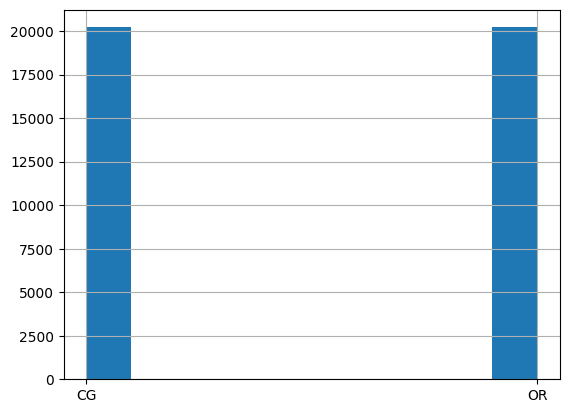

In [6]:
df['label'].hist()
plt.show()

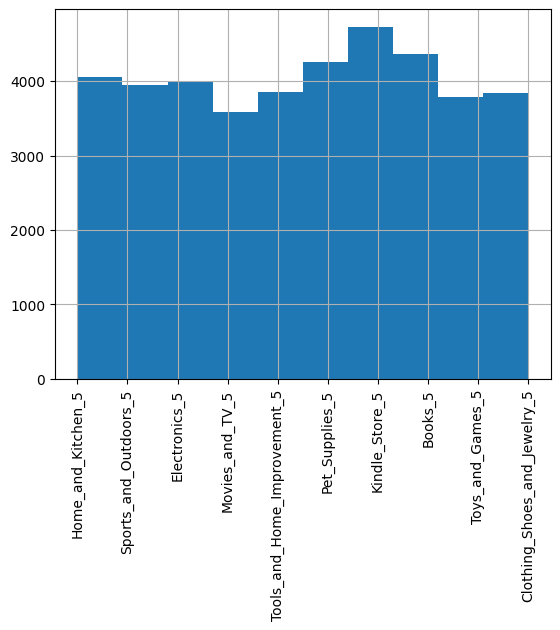

In [7]:
df['category'].hist()
plt.xticks(rotation=90)
plt.show()


In [11]:
df['embed_text'] = 'Category: ' + df['category'] + ' Rating: ' + df['rating'].apply(str) + " Review: " + df['text_']

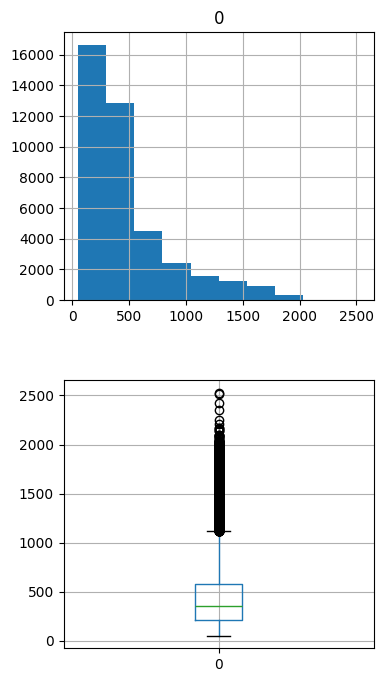

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4, 8))
axes = axes.flatten()
embed_text_list = df['embed_text'].tolist()
embed_lengths = [len(x) for x in embed_text_list]
pd.DataFrame(embed_lengths).hist(ax=axes[0])
pd.DataFrame(embed_lengths).boxplot(ax=axes[1])
plt.show()

# Prepare data

In [13]:
from transformers import RobertaTokenizer
class AmazonFakeReviewDataset(Dataset):
    def __init__(self, df, tokenizer_name="roberta-base", max_len=64): # max_len nhỏ để test cho nhanh
        self.data = df
        self.tokenizer = RobertaTokenizer.from_pretrained(tokenizer_name)
        self.max_len = max_len
        self.label_dict = {"CG": 0, "OR": 1}
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        # Format text giống hệt lúc train thật
        category = str(row['category']).replace("_", " ")
        rating = str(row['rating'])
        review = str(row['text_'])
        
        combined_text = f"Category: {category}. Rating: {rating}. Review: {review}"
        
        encoding = self.tokenizer.encode_plus(
            combined_text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.label_dict[row['label']], dtype=torch.long)
        }

In [14]:
from sklearn.model_selection import train_test_split
def prepare_data(csv_file, batch_size=16):
    df = pd.read_csv(csv_file)
    train_df, test_n_val_df = train_test_split(df, test_size=0.2)
    val_df, test_df = train_test_split(test_n_val_df, test_size=0.5)
    
    train_dataset = AmazonFakeReviewDataset(train_df)
    val_dataset = AmazonFakeReviewDataset(val_df)
    test_dataset = AmazonFakeReviewDataset(test_df)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
    return (train_loader, val_loader, test_loader)

In [15]:
train_loader, val_loader, test_loader = prepare_data("data/Final_enhanced_dataset.csv")

In [16]:
model = FakeDetection(num_classes=2)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
from tqdm import tqdm
from torch.utils.data import TensorDataset
def precompute_features(model, loader, device):
    model.eval()
    features_list = []
    labels_list = []

    with torch.no_grad():
        for batch in tqdm(loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']
            
          
            outputs = model.roberta(input_ids, attention_mask=attention_mask)

            cls_token = outputs.last_hidden_state[:, 0, :].cpu()
            
            features_list.append(cls_token)
            labels_list.append(labels)
            
    all_features = torch.cat(features_list)
    all_labels = torch.cat(labels_list)
    return all_features, all_labels

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
X_train, y_train = precompute_features(model, train_loader, device)
X_val, y_val = precompute_features(model, val_loader, device)

train_ds_fast = TensorDataset(X_train, y_train)
val_ds_fast = TensorDataset(X_val, y_val)

train_loader_fast = DataLoader(train_ds_fast, batch_size=64, shuffle=True)
val_loader_fast = DataLoader(val_ds_fast, batch_size=64)





  0%|          | 0/2022 [00:00<?, ?it/s]

c:\Users\DOOLAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 253/253 [02:52<00:00,  1.47it/s]


In [18]:
classifier_head = model.head.to(device)
optimizer = torch.optim.AdamW(classifier_head.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()



In [19]:
EPOCHS = 15

for epoch in range(EPOCHS):
    classifier_head.train()
    total_loss = 0
    
    for features, labels in train_loader_fast:
        features, labels = features.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = classifier_head(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    avg_loss = total_loss / len(train_loader_fast)
    
    classifier_head.eval()
    val_correct = 0
    with torch.no_grad():
        for features, labels in val_loader_fast:
            features, labels = features.to(device), labels.to(device)
            outputs = classifier_head(features)
            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            
    val_acc = val_correct / len(val_ds_fast)
    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f} | Val Accuracy = {val_acc*100:.2f}%")

Epoch 1: Loss = 0.1457 | Val Accuracy = 97.50%
Epoch 2: Loss = 0.0854 | Val Accuracy = 98.05%
Epoch 3: Loss = 0.0833 | Val Accuracy = 97.92%
Epoch 4: Loss = 0.0841 | Val Accuracy = 98.49%
Epoch 5: Loss = 0.0796 | Val Accuracy = 98.39%
Epoch 6: Loss = 0.0759 | Val Accuracy = 98.39%
Epoch 7: Loss = 0.0762 | Val Accuracy = 98.39%
Epoch 8: Loss = 0.0757 | Val Accuracy = 98.44%
Epoch 9: Loss = 0.0731 | Val Accuracy = 98.52%
Epoch 10: Loss = 0.0741 | Val Accuracy = 98.14%
Epoch 11: Loss = 0.0704 | Val Accuracy = 98.57%
Epoch 12: Loss = 0.0704 | Val Accuracy = 98.69%
Epoch 13: Loss = 0.0696 | Val Accuracy = 98.05%
Epoch 14: Loss = 0.0686 | Val Accuracy = 98.74%
Epoch 15: Loss = 0.0668 | Val Accuracy = 98.27%


In [20]:
model.eval()
test_correct = 0
for x in test_loader:
    input_ids = x['input_ids'].to(device)
    attention_mask = x['attention_mask'].to(device)
    labels = x['labels'].to(device)
    logits = model(input_ids, attention_mask)
    preds = torch.argmax(logits, dim=1)
    test_correct += (preds == labels).sum().item()
    
test_acc = val_correct / len(val_ds_fast)
print(test_acc)

0.9826861241652238


In [21]:
torch.save(model.state_dict(), 'model_weights.pth') 